In [1]:
import sys
import os


current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# load datasets
full_data = pd.read_csv('../data/legend.csv')
full_data['label_idx'] = full_data['emotion'].str.lower()

unique_labels = sorted(full_data['label_idx'].unique())
label_to_int = {label: i for i, label in enumerate(unique_labels)}
int_to_label = {i: label for label, i in label_to_int.items()}
full_data['label_idx'] = full_data['label_idx'].map(label_to_int)
print(f"Labels: {unique_labels}")

# split datasets
train_df, val_df = train_test_split(
    full_data, test_size=0.2, stratify=full_data['emotion'], random_state=42)
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

Labels: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
Training samples: 10952, Validation samples: 2738


In [4]:
print(train_df['emotion'].str.lower().value_counts())

most_common_idx = train_df['label_idx'].value_counts().idxmax()
print("Most common label index (train):", most_common_idx)
print("Most common label:", int_to_label[most_common_idx])

emotion
neutral      5495
happiness    4557
surprise      295
sadness       214
anger         202
disgust       166
fear           16
contempt        7
Name: count, dtype: int64
Most common label index (train): 5
Most common label: neutral


In [5]:
# Predictions for train and val
train_preds = np.full(len(train_df), most_common_idx)
val_preds = np.full(len(val_df), most_common_idx)

# True labels
train_true = train_df['label_idx'].values
val_true = val_df['label_idx'].values

# Accuracy
train_accuracy = (train_preds == train_true).mean()
val_accuracy  = (val_preds == val_true).mean()

print("Training accuracy:", train_accuracy)
print("Validation accuracy:", val_accuracy)

Training accuracy: 0.5017348429510592
Validation accuracy: 0.5014609203798392


In [6]:
eps = 1e-12  # avoid log(0)

# For each sample, prob = 1 if correct, epsilon if incorrect
train_probs = np.where(train_preds == train_true, 1 - eps, eps)
val_probs   = np.where(val_preds == val_true, 1 - eps, eps)

train_loss = -np.mean(np.log(train_probs))
val_loss   = -np.mean(np.log(val_probs))

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 13.767575075751237
Validation loss: 13.775143836100742


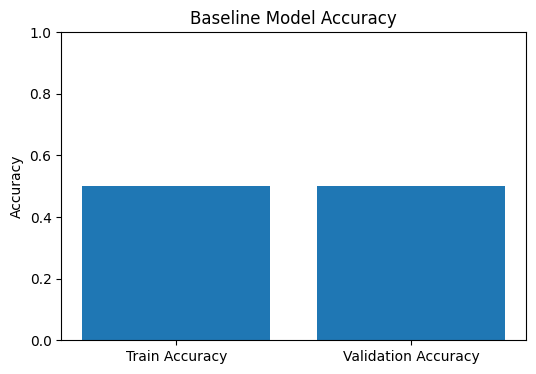

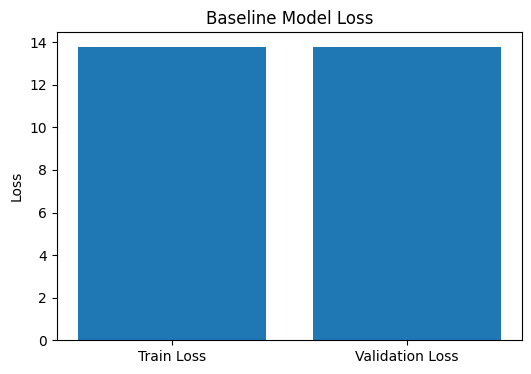

In [7]:
plt.figure(figsize=(6,4))
plt.bar(
    ["Train Accuracy", "Validation Accuracy"],
    [train_accuracy, val_accuracy]
)
plt.ylabel("Accuracy")
plt.title("Baseline Model Accuracy")
plt.ylim(0, 1)  # optional but recommended for accuracy
plt.show()

# -------------------------------
# Loss Bar Graph
# -------------------------------
plt.figure(figsize=(6,4))
plt.bar(
    ["Train Loss", "Validation Loss"],
    [train_loss, val_loss]
)
plt.ylabel("Loss")
plt.title("Baseline Model Loss")
plt.show()

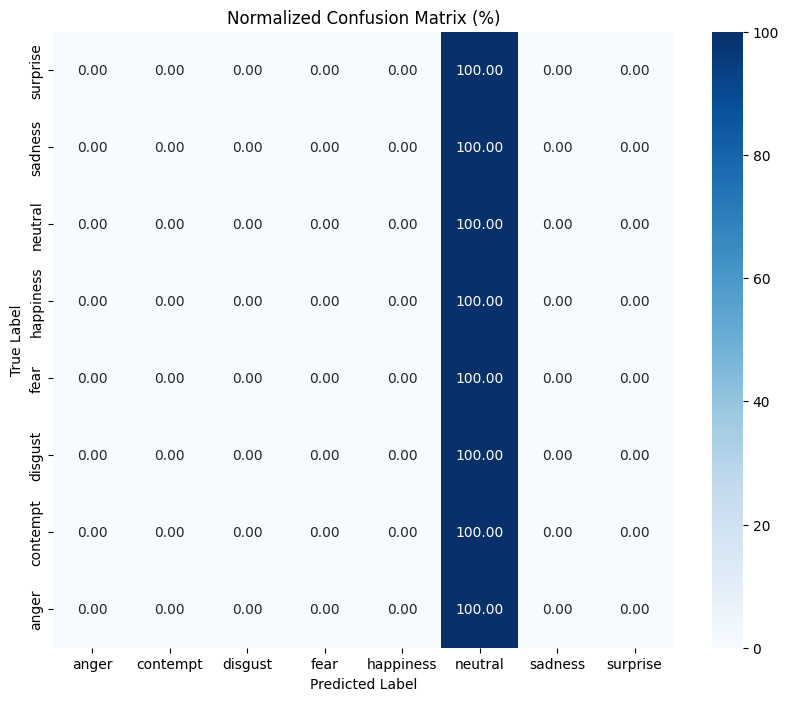


Per-class accuracy:
anger: 0.00%
contempt: 0.00%
disgust: 0.00%
fear: 0.00%
happiness: 0.00%
neutral: 100.00%
sadness: 0.00%
surprise: 0.00%

Weighted F1-Score: 0.3350


In [8]:
# confusion matrix
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np


all_predictions = [most_common_idx]*len(val_df)
all_labels = list(val_df['label_idx'].values) 

cm = confusion_matrix(all_labels, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels[::-1])
plt.title('Normalized Confusion Matrix (%)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nPer-class accuracy:")
for i, label in enumerate(unique_labels):
    print(f"{label}: {cm_normalized[i, i]:.2f}%")

# f1-score
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f"\nWeighted F1-Score: {f1:.4f}")